In [33]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from open_abf import plot_swps, get_sweeps
from scipy.optimize import leastsq
%matplotlib widget

### Define your path to your data
#### The glob function helps you filter your files

In [34]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Kv',
 '/home/alan/Documents/LAB/CSHL/Data/Nav']

In [38]:
files = glob(folders[1]+"/*")
files

['/home/alan/Documents/LAB/CSHL/Data/Nav/24607007_reco-100.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607005_IV.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607010_reco-110.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607008-reco-90.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607006_inact.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607020_IV2.abf']

### IV curve

In [40]:
iv_files = glob(folders[1]+"/*IV*")
iv_files

['/home/alan/Documents/LAB/CSHL/Data/Nav/24607005_IV.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607020_IV2.abf']

#### plot_swps(f) will show all the sweeps from the recordings

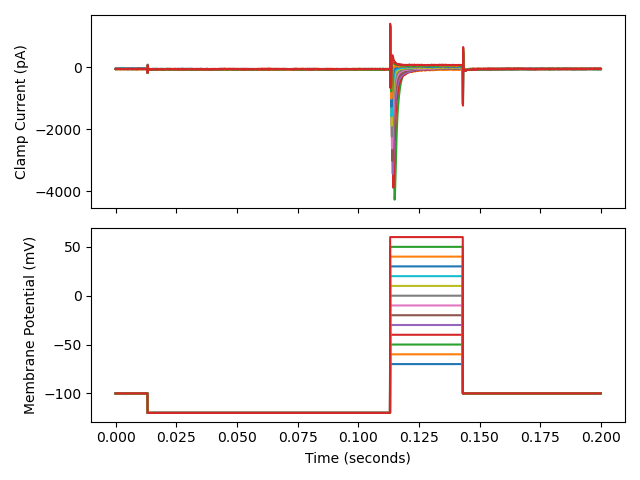

In [41]:
plt.close('all')
f = iv_files[0]
plot_swps(f)

#### get_sweep(f) extract the sweeps from your recording along the time axis (swp_time) and the sampling rate (sr)
#### swps.shape give you the dimensions of your sweeps:
#### (number of sweeps, number of channel, number of point per sweep)

In [42]:
swps, swp_time, sr = get_sweeps(f)
swps.shape

(14, 2, 10000)

### swp_window function will extract the data from the sweeps from a given time window.
#### start and end or in seconds.

In [43]:
def swp_window(swps,start,end,sr,channel=0):
    i_start = int(start * sr)
    i_end = int(end * sr)
    return swps[:,channel,i_start:i_end]

### using numpy (np) functions to:
#### mean (np.mean())
#### max (np.max())
#### min (np.min())
#### The axis parameter gives the dimension on which you apply the function 

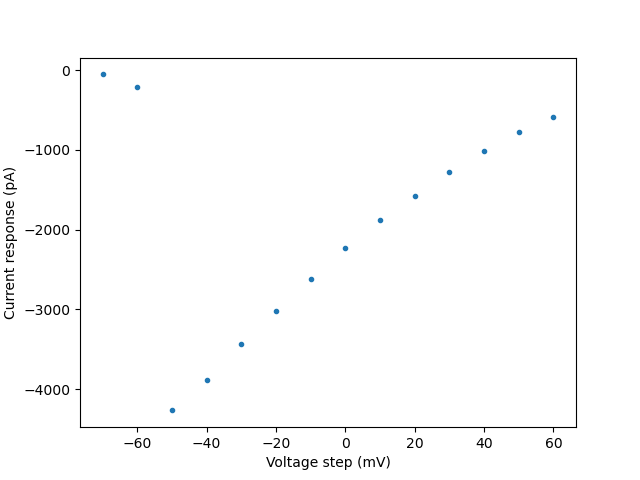

In [46]:
## The mean on your voltage step:
v_start = 0.1135
v_end = 0.14
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the pic response in your current:
i_start = 0.11341
i_end = 0.1155
current_window = swp_window(swps,i_start,i_end,sr,channel=0)
current_response = [swp[np.argmax(np.abs(swp))] for swp in current_window]
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()

### Activation Curve

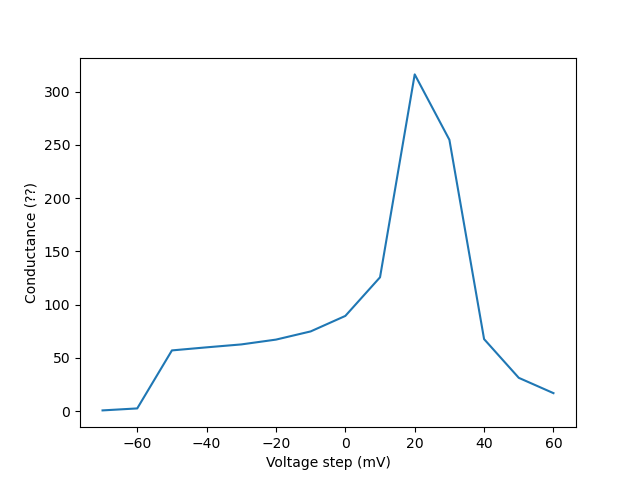

In [48]:
## reversal potential in mV
E_rev = 25 
conductance = current_response/(voltage_step - E_rev)
fig, ax = plt.subplots()
ax.plot(voltage_step,abs(conductance))
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Conductance (??)')
plt.show()

### Normalise  

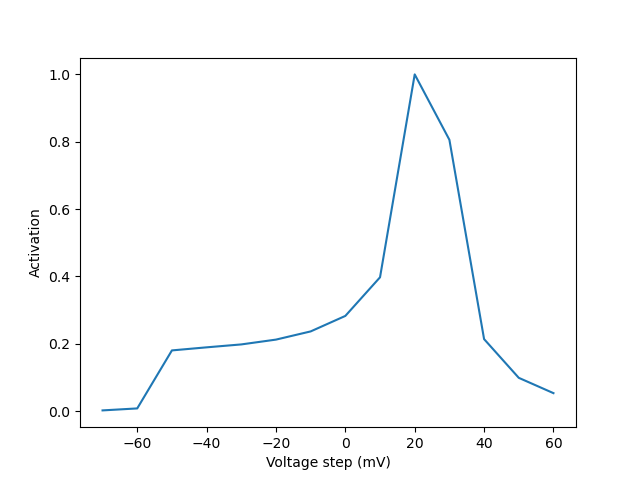

In [51]:
conductance =np.abs(conductance)
activation = conductance/conductance.max()
fig, ax = plt.subplots()
ax.plot(voltage_step,activation)
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Activation')
plt.show()

In [52]:
def fun_boltz(x, p):
    """Fit function for growth: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0 - (1.0/(1.0+np.exp((x-p[0])/p[1])))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = activation
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax.plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax.legend()

[ 95.9152 104.7931]


### Recovery rotocols

In [28]:
files = glob(folders[0]+"/*reco*")
files

['/home/alan/Documents/LAB/CSHL/Data/Nav/24607007_reco-100.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607010_reco-110.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607008-reco-90.abf']

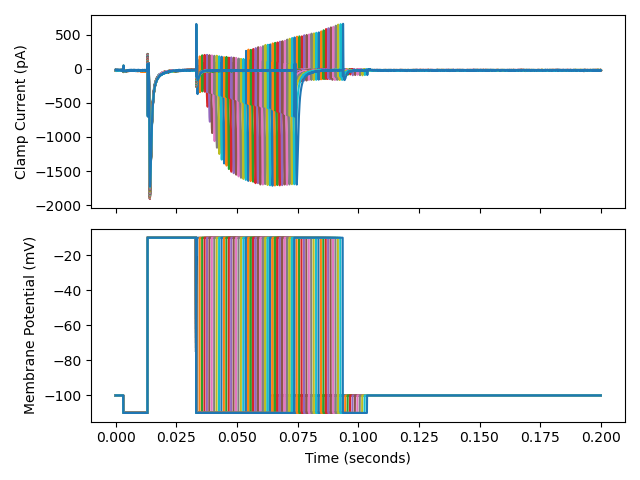

In [29]:
f = files[1]
plot_swps(f)

### Check the stability of your reference current response from the activation step:

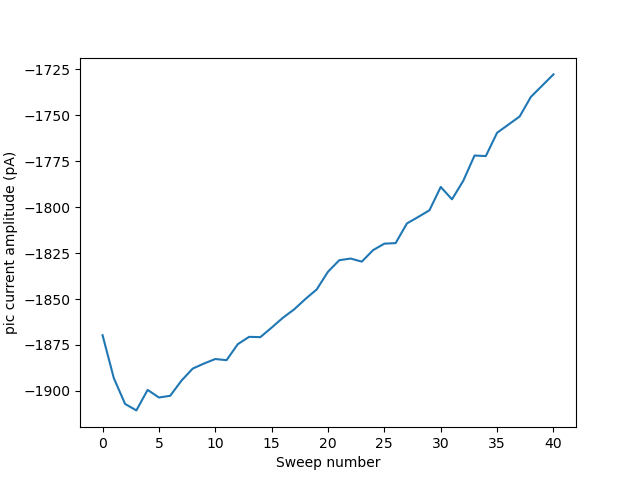

In [12]:
swps, swp_time, sr = get_sweeps(f)
ref_current = np.min(swp_window(swps,0.013,0.016,sr,channel=0),axis=1)
fig, ax = plt.subplots()
ax.plot(ref_current)
ax.set_xlabel('Sweep number')
ax.set_ylabel('pic current amplitude (pA)')
plt.show()

### Create the time interval array from your protocol: 

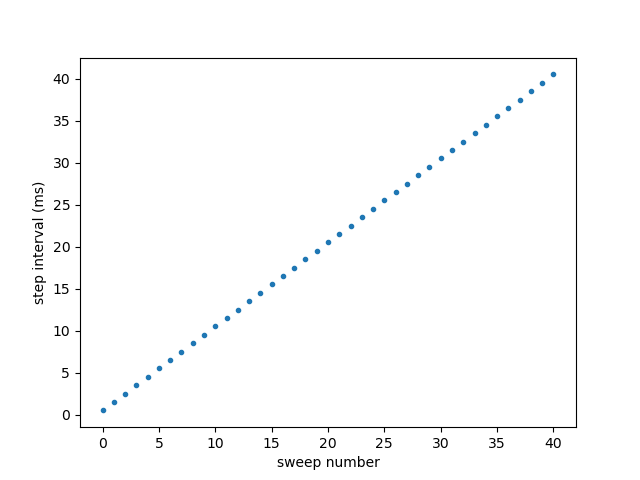

In [13]:
nb_sweep = len(swps)
first_interval = 0.5 # ms
interval = 1 #ms
time_int = np.arange(nb_sweep)*interval + first_interval
fig,ax = plt.subplots()
ax.plot(time_int,'.')
ax.set_xlabel('sweep number')
ax.set_ylabel('step interval (ms)')
plt.show()

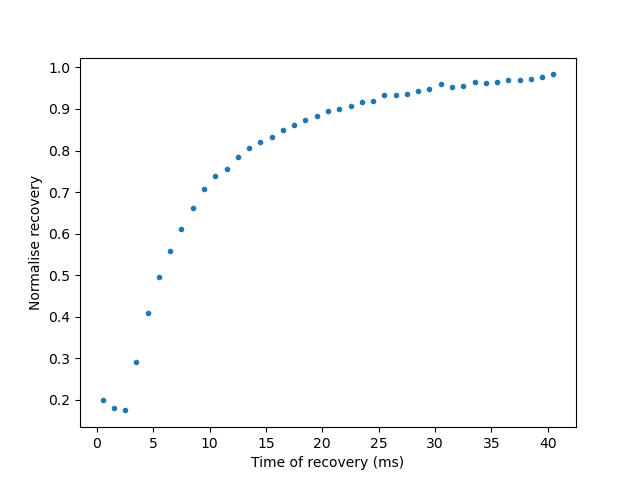

In [14]:
i_start = 0.0335
i_end = 0.08
reco_current = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
fig,ax = plt.subplots()
ax.plot(time_int,reco_current/ref_current,'.',label='data')
ax.set_xlabel('Time of recovery (ms)')
ax.set_ylabel('Normalise recovery')
plt.show()

### Lets fit this to an exponential function 

In [15]:
def fun_exp(t, p):
    """Fit function for decay: single exponential + offset
    p[0] : amplitude
    p[1] : tau
    p[2] : offset
    """
    return 1 - (np.exp(-t/p[1])+ p[2])

def minimize_fun(p, x, y):
    return y-fun_exp(x, p)

x = time_int
y = reco_current/ref_current
p_guess = [1,1,0]
fit_exp = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_exp

(array([1.    , 7.9037, 0.019 ]),
 None,
 {'fvec': array([ 0.1569,  0.0277, -0.0773, ...,  0.    ,  0.0026,  0.0082]),
  'nfev': 33,
  'fjac': array([[-6.4031,  0.1562,  0.1562, ...,  0.1562,  0.1562,  0.1562],
         [-0.1509,  0.0938, -0.0828, ...,  0.1777,  0.1825,  0.1869],
         [ 0.    ,  0.    , -0.    , ...,  0.    ,  0.    ,  0.    ]]),
  'ipvt': array([3, 2, 1], dtype=int32),
  'qtf': array([-0.   , -0.   , -0.098])},
 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 1)

In [16]:
fit_params = fit_exp[0]
fit_params

array([1.    , 7.9037, 0.019 ])

In [17]:
fit_fun = fun_exp(x,fit_exp[0])
ax.plot(x,fit_fun,label=f"fit\n tau={fit_params[1]} ms")
ax.legend()

### Inactivation Protocol

In [30]:
files = glob(folders[0]+"/*inact*")
files

['/home/alan/Documents/LAB/CSHL/Data/Nav/24607006_inact.abf']

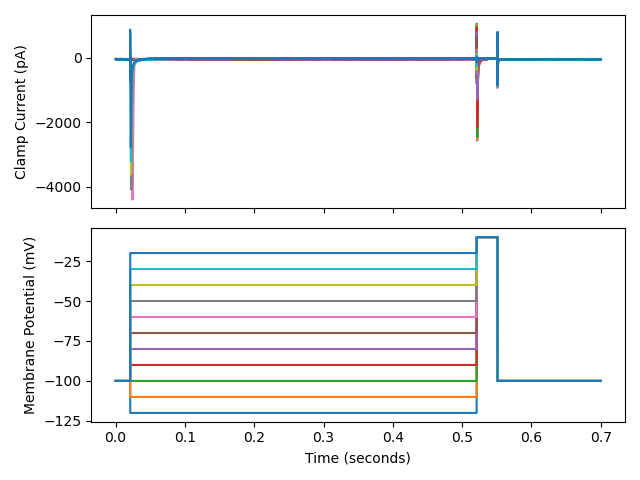

In [31]:
f = files[0]
plot_swps(f)

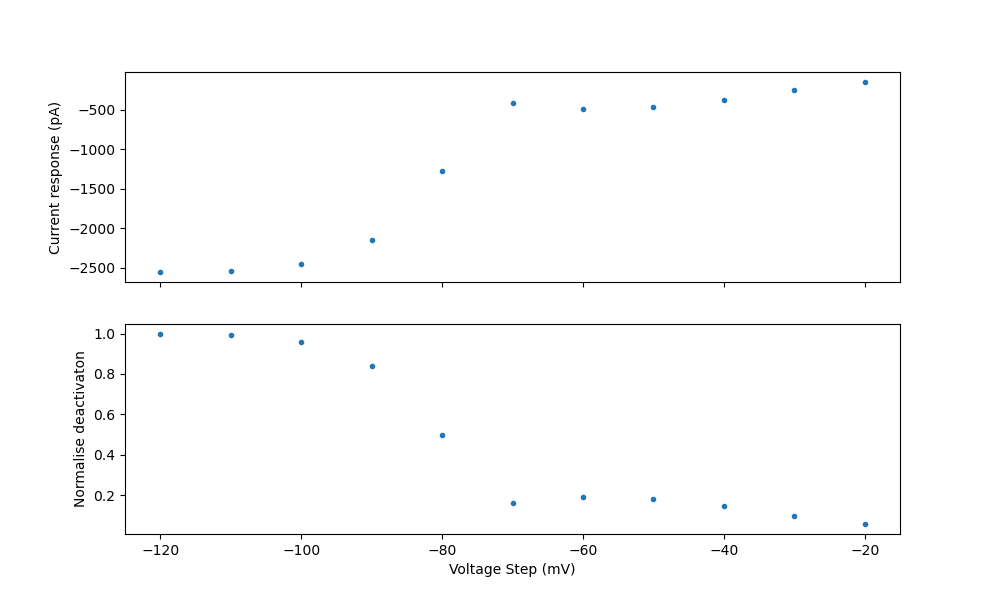

In [20]:
## Get the sweeps
swps, swp_time, sr = get_sweeps(f)
## define your voltage step window channel 1
v_start = 0.1135
v_end = 0.52
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## define your current step window channel 0
i_start = 0.1
i_end = 0.523
current_response = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## Create a figure with two subplots (ax[0] and ax[1])
## The sharex=True makes the two subplots share the same x axis. 
fig,ax = plt.subplots(2,sharex=True,figsize=(10,6))
ax[0].plot(voltage_step,current_response,'.')
ax[0].set_ylabel('Current response (pA)')
ax[1].plot(voltage_step,current_response/current_response.min(),'.')
ax[1].set_ylabel('Normalise deactivaton')
ax[1].set_xlabel('Voltage Step (mV)')
plt.show()

### Lets fit a Boltzman function 

In [21]:
def fun_boltz(x, p):
    """Fit function for decay: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0/(1.0+np.exp((x-p[0])/p[1]))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = current_response/current_response.min()
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_boltz

(array([-78.861 ,   8.7861]),
 array([[527.1933,  -0.1127],
        [ -0.1127, 409.5868]]),
 {'fvec': array([0.0092, 0.0189, 0.0422, ..., 0.1323, 0.0953, 0.054 ]),
  'nfev': 131,
  'fjac': array([[-0.0494,  0.2228,  0.4205, ..., -0.1194, -0.0489, -0.019 ],
         [-0.    ,  0.0436,  0.1893, ...,  0.0332,  0.011 ,  0.0036]]),
  'ipvt': array([2, 1], dtype=int32),
  'qtf': array([-0.,  0.])},
 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 1)

In [22]:
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax[1].plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax[1].legend()

[-78.861    8.7861]
